# **1. Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **2. Dummy Data Generation**

In [2]:
def generate_marketing_data(n_samples=1000):
    """
    Features:
        - Age (roughly 18-65)
        - Estimated Salary (roughly 20k-150k)
    Label:
        - Purchased (0 or 1)
    """
    np.random.seed(42)

    # Feature 1: Age (Mean=40, Std=10)
    age = np.random.normal(40, 10, n_samples)
    age = np.clip(age, 18, 65) # Clip to realistic ages

    # Feature 2: Salary (Mean=80k, Std=30k)
    salary = np.random.normal(80000, 30000, n_samples)
    salary = np.clip(salary, 20000, 150000)

    # Logic: Older people with higher salary are more likely to buy.
    score = (age * 600) + salary + np.random.normal(0, 15000, n_samples)

    # Threshold determines the class split (approx 50/50 split here)
    threshold = 110000
    y = (score > threshold).astype(int)

    return age, salary, y

# **3. Preprocessing Funtions**

### Normalize Data to Get Features in Same Scale

In [3]:
def normalize_data(X):
    # Calculate mean and std
    mu = np.mean(X, axis=1, keepdims=True)
    sigma = np.std(X, axis=1, keepdims=True)

    # Avoid division by zero
    sigma[sigma == 0] = 1e-8

    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

### Split Data into Train and Test Sets

In [4]:

def train_test_split(X, Y, test_ratio=0.2):
    m = X.shape[1]
    test_size = int(m * test_ratio)

    # Generate random permutation of indices
    indices = np.random.permutation(m)
    train_idx, test_idx = indices[test_size:], indices[:test_size]

    # Slice the arrays
    X_train, X_test = X[:, train_idx], X[:, test_idx]
    Y_train, Y_test = Y[:, train_idx], Y[:, test_idx]

    return X_train, Y_train, X_test, Y_test

# **4. Initialize Paramters and Activation Functions**

In [5]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Initialize weights (W) and biases (b).
    n_x: input size, n_h: hidden size, n_y: output size
    """
    # He Initialization for ReLU layer
    W1 = np.random.randn(n_h, n_x) * np.sqrt(2. / n_x)
    b1 = np.zeros((n_h, 1))

    # Xavier Initialization for Sigmoid layer
    W2 = np.random.randn(n_y, n_h) * np.sqrt(1. / n_h)
    b2 = np.zeros((n_y, 1))

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

# **5. Neural Network Core Functionality**

### **Forward Propogation**

##### Computes the network output.
##### Z = WX + b
##### A = activation(Z)

In [6]:
def forward_propagation(X, parameters):
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]

    # Layer 1 (Hidden: Linear -> ReLU)
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    # Layer 2 (Output: Linear -> Sigmoid)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

### **Computer Cost**
##### Computes Binary Cross-Entropy Cost.


In [7]:
def compute_cost(A2, Y):
    m = Y.shape[1]
    # Epsilon to prevent log(0)
    epsilon = 1e-15
    cost = -np.sum(Y * np.log(A2 + epsilon) + (1 - Y) * np.log(1 - A2 + epsilon)) / m
    return np.squeeze(cost)

### **Backward Propogation**
##### Computes gradients using the Chain Rule.





In [8]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W2 = parameters["W2"]
    A1, A2 = cache["A1"], cache["A2"]
    Z1 = cache["Z1"]

    # Output Layer Gradients
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden Layer Gradients
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0) # Derivative of ReLU is 1 if Z>0 else 0

    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

### **Update Parameters**
##### Gradient Descent Update Rule: theta = theta - alpha * d_theta

In [9]:
def update_parameters(parameters, grads, learning_rate):
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]
    return parameters

# **6. Training Loop**

In [10]:
def train_model(X_train, Y_train, n_h, num_iterations=10000, learning_rate=0.01, print_cost=False):
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]

    parameters = initialize_parameters(n_x, n_h, n_y)
    costs = []

    for i in range(num_iterations):
        # 1. Forward
        A2, cache = forward_propagation(X_train, parameters)

        # 2. Cost
        cost = compute_cost(A2, Y_train)

        # 3. Backward
        grads = backward_propagation(parameters, cache, X_train, Y_train)

        # 4. Update
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 1000 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Iteration {i}: Cost {cost:.5f}")

    return parameters, costs

# **7. Prediction and Visualization**

In [11]:
def predict(parameters, X):
    A2, _ = forward_propagation(X, parameters)
    return (A2 > 0.5).astype(int)

def plot_decision_boundary(parameters, X, Y):
    # Determine grid range based on normalized data
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten grid, predict, and reshape
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Z_pred = predict(parameters, grid_points)
    Z_pred = Z_pred.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z_pred, cmap="coolwarm", alpha=0.3)
    plt.scatter(X[0, :], X[1, :], c=Y.ravel(), cmap="coolwarm", edgecolors='k')
    plt.title("Decision Boundary (Normalized Scale)\nRed=Purchased, Blue=Not Purchased")
    plt.xlabel("Age (Normalized)")
    plt.ylabel("Salary (Normalized)")
    plt.show()

# **8. Execution**

In [12]:
if __name__ == "__main__":
    # Generate Data
    print("Generating Marketing Data...")
    age, salary, labels = generate_marketing_data(n_samples=1000)

    # Reshape for Network
    X_raw = np.vstack((age, salary))
    Y_raw = labels.reshape(1, -1)

    # Normalize
    print("Normalizing Features...")
    X_norm, mu, sigma = normalize_data(X_raw)

    # Split Train/Test
    X_train, Y_train, X_test, Y_test = train_test_split(X_norm, Y_raw, test_ratio=0.2)
    print(f"Training Data: {X_train.shape} | Test Data: {X_test.shape}")

    # Train Network
    print("\nStarting Training...")
    # Using 8 hidden neurons for this complexity
    params, cost_history = train_model(
        X_train, Y_train,
        n_h=8,
        num_iterations=20000,
        learning_rate=0.1,
        print_cost=True
    )

Generating Marketing Data...
Normalizing Features...
Training Data: (2, 800) | Test Data: (2, 200)

Starting Training...
Iteration 0: Cost 0.55161
Iteration 1000: Cost 0.30653
Iteration 2000: Cost 0.30579
Iteration 3000: Cost 0.30557
Iteration 4000: Cost 0.30531
Iteration 5000: Cost 0.30504
Iteration 6000: Cost 0.30479
Iteration 7000: Cost 0.30454
Iteration 8000: Cost 0.30431
Iteration 9000: Cost 0.30411
Iteration 10000: Cost 0.30392
Iteration 11000: Cost 0.30375
Iteration 12000: Cost 0.30359
Iteration 13000: Cost 0.30346
Iteration 14000: Cost 0.30335
Iteration 15000: Cost 0.30324
Iteration 16000: Cost 0.30314
Iteration 17000: Cost 0.30306
Iteration 18000: Cost 0.30299
Iteration 19000: Cost 0.30293


# **9. Evaluate and Visualize**


Final Training Accuracy: 87.12%
Final Test Accuracy:     86.50%


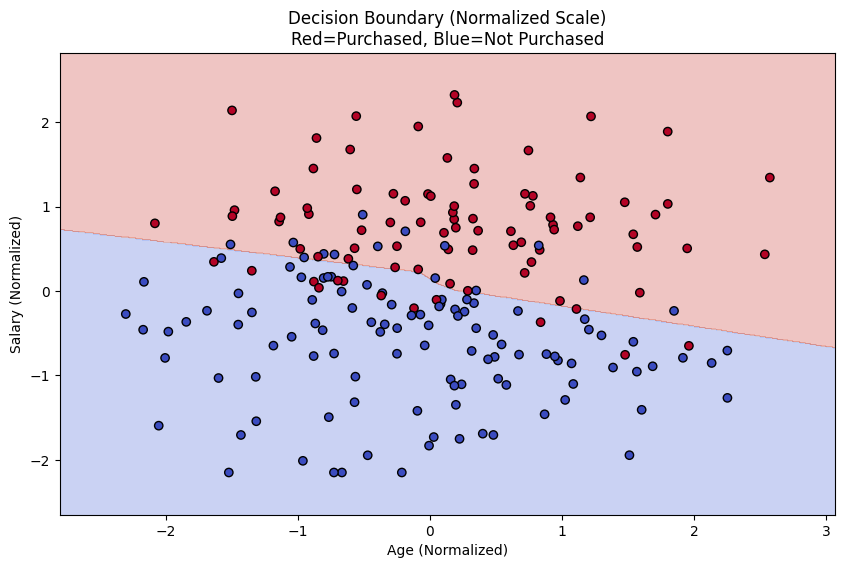

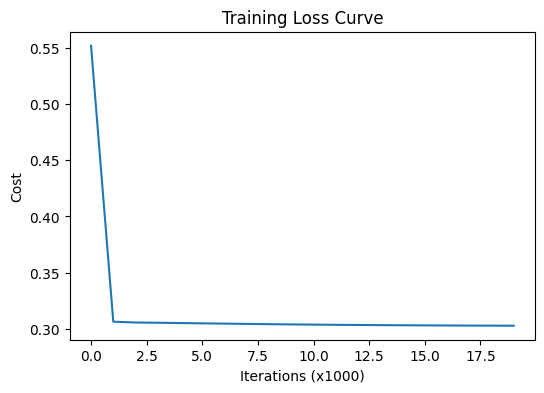

In [13]:
    # Evaluate
    train_acc = np.mean(predict(params, X_train) == Y_train) * 100
    test_acc = np.mean(predict(params, X_test) == Y_test) * 100

    print(f"\nFinal Training Accuracy: {train_acc:.2f}%")
    print(f"Final Test Accuracy:     {test_acc:.2f}%")

    # Visualize
    plot_decision_boundary(params, X_test, Y_test)

    # Visualize Loss
    plt.figure(figsize=(6,4))
    plt.plot(cost_history)
    plt.title("Training Loss Curve")
    plt.xlabel("Iterations (x1000)")
    plt.ylabel("Cost")
    plt.show()